# Example climb: Low Pearson correlation & low entropy

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, entropy

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [ ]:
# Number of input data points
n = 5000

# Run duration in minutes
run_time = 60

# Number of replicate climbs
replicates = 8

### 1.3. Input distributions

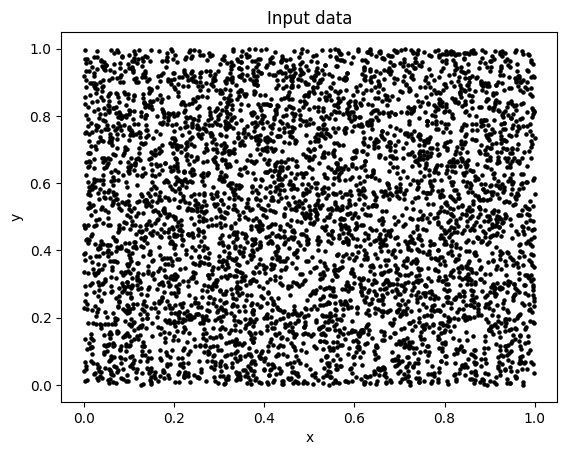

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.rand(n),
    'y': np.random.rand(n)
})

plt.title('Input data')
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Minimize correlation and entropy

### 2.1. Objective function

In [4]:
def objective_low_correlation_low_entropy(x, y):
    '''Minimize both Pearson correlation and joint entropy while preventing outliers.
    
    Balanced objective that allows optimization progress while discouraging extreme points.
    '''

    # Convert to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Basic validation
    if len(x) == 0 or len(y) == 0 or len(x) != len(y):
        return {'error': 'invalid_input'}, -1000.0
    
    # Calculate Pearson correlation (with fallback)
    try:
        pearson_corr = pearsonr(x, y)[0]

        if np.isnan(pearson_corr):
            pearson_corr = 0.0

    except:
        pearson_corr = 0.0
    
    # Calculate joint entropy using 2D histogram
    try:
        n_bins = 20
        hist_2d, _, _ = np.histogram2d(x, y, bins=n_bins)
        hist_flat = hist_2d.flatten()
        
        if hist_flat.sum() == 0:
            joint_entropy = 0.0

        else:
            hist_prob = hist_flat / hist_flat.sum()
            joint_entropy = entropy(hist_prob + 1e-10)
            
    except:
        joint_entropy = 5.0
    
    # Add outlier penalty using standard deviations (gentler than IQR)
    def outlier_penalty(data):

        try:
            if len(data) < 3:
                return 0.0

            mean_val = np.mean(data)
            std_val = np.std(data)

            if std_val == 0:
                return 0.0

            # Count points more than 2 standard deviations from mean
            z_scores = np.abs((data - mean_val) / std_val)
            outliers = np.sum(z_scores > 2.5)
            return outliers / len(data)

        except:
            return 0.0
    
    outlier_penalty_x = outlier_penalty(x)
    outlier_penalty_y = outlier_penalty(y)
    total_outlier_penalty = outlier_penalty_x + outlier_penalty_y
    
    # Encourage reasonable data spread (not too compact, not too spread)
    x_range = np.ptp(x)  # max - min
    y_range = np.ptp(y)
    
    # Ideal range is moderate use of [0,1] space
    ideal_min_range = 0.3  # At least 30% of space
    ideal_max_range = 0.9  # At most 90% of space
    
    range_penalty = 0.0

    if x_range < ideal_min_range:
        range_penalty += (ideal_min_range - x_range)

    elif x_range > ideal_max_range:
        range_penalty += (x_range - ideal_max_range)
        
    if y_range < ideal_min_range:
        range_penalty += (ideal_min_range - y_range)

    elif y_range > ideal_max_range:
        range_penalty += (y_range - ideal_max_range)
    
    # Balanced objective with moderate penalties
    correlation_penalty = 0.3 * abs(pearson_corr)
    entropy_penalty = 0.3 * joint_entropy
    outlier_penalty_weighted = 1.0 * total_outlier_penalty  # Strong outlier penalty
    range_penalty_weighted = 0.3 * range_penalty
    
    objective = -(correlation_penalty + entropy_penalty + outlier_penalty_weighted + range_penalty_weighted)
    
    metrics = {
        'Pearson coefficient': float(pearson_corr),
        'Joint Entropy': float(joint_entropy),
        'Outlier Penalty': float(total_outlier_penalty),
        'Range Penalty': float(range_penalty),
        'Combined Score': float(correlation_penalty + entropy_penalty)
    }
    
    return metrics, float(objective)

### 2.2. Run parameters

In [5]:
# Set hyperparameters - more aggressive for faster progress
step_size = 1.0
perturb_fraction = 0.2
temperature = 100.0
initial_noise = 0.3
cooling_rate = 0.999
objective_func = objective_low_correlation_low_entropy

### 2.3. Hill climbing run

In [6]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_func,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.4. Results

IndexError: single positional indexer is out-of-bounds

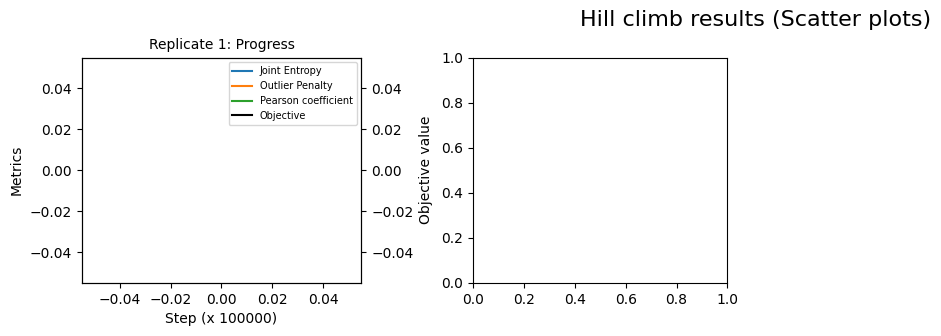

In [7]:
# Display key metrics including outlier penalty
climber.plot_results(results, metrics=['Joint Entropy', 'Outlier Penalty', 'Pearson coefficient'])

In [ ]:
# Save the climber object
with open('../data/04_low_correlation_low_entropy.pkl', 'wb') as f:
    pickle.dump(climber, f)